<a href="https://colab.research.google.com/github/rsbaye/Data-Science-Projects/blob/main/Cost_effectiveness_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from dataclasses import dataclass
from typing import Dict
from copy import deepcopy
from scipy import stats
import seaborn as sns
from typing import Dict, List


In [27]:

@dataclass
class MarkovParameters:
    # Transition probabilities
    tp_prog: float  # Progression probability
    tp_dcm: float   # Death from complications probability
    tp_dn: Dict[str, float]  # Death from natural causes by age group

    # Costs
    costs: Dict[str, float]

    # Utilities
    utilities: Dict[str, float]

    # Other parameters
    cycle_length: float
    effectiveness: float
    initial_age: int
    outcome_discount: float
    cost_discount: float

class MarkovModel:
    def __init__(self, params: MarkovParameters):
        self.params = params
        self.states = ['Asymptomatic', 'Progressive', 'Death']

    def get_age_group(self, age: int) -> str:
        """Determine age group for natural death probability."""
        if age < 65:
            return "55-64"
        elif age < 75:
            return "65-74"
        elif age < 85:
            return "75-84"
        else:
            return "85+"

    def build_transition_matrix(self, age: int) -> np.ndarray:
        """Build transition probability matrix for given age."""
        tp_dn = self.params.tp_dn[self.get_age_group(age)]

        # Matrix structure: [Asymptomatic, Progressive, Death]
        matrix = np.zeros((3, 3))

        # From Asymptomatic
        matrix[0, 0] = 1 - self.params.tp_prog - tp_dn  # Stay in Asymptomatic
        matrix[0, 1] = self.params.tp_prog              # Progress to Progressive
        matrix[0, 2] = tp_dn                            # Die from natural causes

        # From Progressive
        matrix[1, 1] = 1 - self.params.tp_dcm - tp_dn   # Stay in Progressive
        matrix[1, 2] = self.params.tp_dcm + tp_dn       # Die (complications or natural)

        # From Death (absorbing state)
        matrix[2, 2] = 1.0

        return matrix

    def run_simulation(self, n_cycles: int):
        """Run Markov model simulation."""
        # Initialize trackers
        cohort = np.array([1.0, 0.0, 0.0])  # Start all patients in Asymptomatic
        age = self.params.initial_age

        # Storage for results
        state_history = [cohort.copy()]
        costs = []
        qalys = []

        for cycle in range(n_cycles):
            # Get transition matrix for current age
            P = self.build_transition_matrix(age)

            # Calculate new state distribution
            cohort = cohort @ P

            # Calculate costs for this cycle
            cycle_costs = (
                cohort[0] * self.params.costs['cAsymp'] +
                cohort[1] * (self.params.costs['cProg'] + self.params.costs['cDrug']) +
                cohort[2] * self.params.costs['cDeath']
            )

            # Calculate QALYs for this cycle
            cycle_qalys = (
                cohort[0] * self.params.utilities['uAsymp'] +
                cohort[1] * self.params.utilities['uProg']
            )

            # Apply discounting
            discount_factor = 1 / (1 + self.params.outcome_discount/100) ** cycle
            costs.append(cycle_costs * discount_factor)
            qalys.append(cycle_qalys * discount_factor)

            # Store state distribution
            state_history.append(cohort.copy())

            # Increment age
            age += self.params.cycle_length

        return {
            'state_history': np.array(state_history),
            'total_costs': sum(costs),
            'total_qalys': sum(qalys)
        }

# Initialize parameters
params = MarkovParameters(
    tp_prog=0.01,
    tp_dcm=0.15,
    tp_dn={
        "55-64": 0.0138,
        "65-74": 0.0379,
        "75-84": 0.0912,
        "85+": 0.1958
    },
    costs={
        'cAsymp': 500,
        'cProg': 3000,
        'cDrug': 1000,
        'cDeath': 1000
    },
    utilities={
        'uAsymp': 0.95,
        'uProg': 0.75
    },
    cycle_length=1,
    effectiveness=50,
    initial_age=55,
    outcome_discount=6,
    cost_discount=6
)

# Create model and run simulation
model = MarkovModel(params)
results = model.run_simulation(n_cycles=20)  # Run for 20 years

# Print results
print(f"Total costs: £{results['total_costs']:,.2f}")
print(f"Total QALYs: {results['total_qalys']:.2f}")

Total costs: £8,572.37
Total QALYs: 9.46



Cost-Effectiveness Analysis Results:
Intervention Costs: £7,783.46
Intervention QALYs: 9.67
Baseline Costs: £8,162.48
Baseline QALYs: 9.46
Incremental Costs: £-379.02
Incremental QALYs: 0.22
ICER: £-1,744.95 per QALY gained


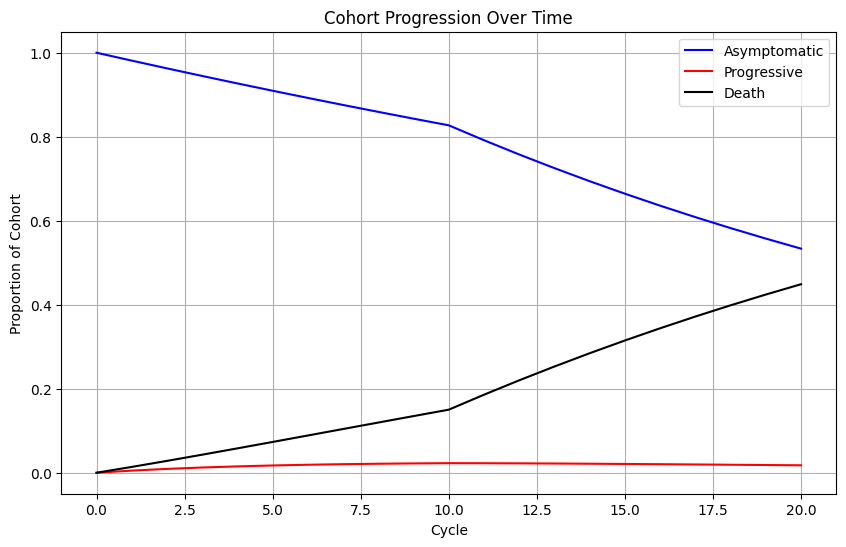

In [28]:


@dataclass
class MarkovParameters:
    # Previous parameters remain the same
    tp_prog: float
    tp_dcm: float
    tp_dn: Dict[str, float]
    costs: Dict[str, float]
    utilities: Dict[str, float]
    cycle_length: float
    effectiveness: float
    initial_age: int
    outcome_discount: float
    cost_discount: float

class MarkovModel:
    def __init__(self, params: MarkovParameters):
        self.params = params
        self.states = ['Asymptomatic', 'Progressive', 'Death']

    def get_age_group(self, age: int) -> str:
        if age < 65:
            return "55-64"
        elif age < 75:
            return "65-74"
        elif age < 85:
            return "75-84"
        else:
            return "85+"

    def build_transition_matrix(self, age: int, with_intervention: bool = True) -> np.ndarray:
        """Build transition matrix with option for intervention effect."""
        tp_dn = self.params.tp_dn[self.get_age_group(age)]

        # Apply effectiveness to progression rate if intervention is active
        tp_prog = self.params.tp_prog
        if with_intervention:
            tp_prog *= (1 - self.params.effectiveness/100)

        matrix = np.zeros((3, 3))
        matrix[0, 0] = 1 - tp_prog - tp_dn
        matrix[0, 1] = tp_prog
        matrix[0, 2] = tp_dn
        matrix[1, 1] = 1 - self.params.tp_dcm - tp_dn
        matrix[1, 2] = self.params.tp_dcm + tp_dn
        matrix[2, 2] = 1.0

        return matrix

    def run_simulation(self, n_cycles: int, with_intervention: bool = True):
        cohort = np.array([1.0, 0.0, 0.0])
        age = self.params.initial_age

        state_history = [cohort.copy()]
        costs = []
        qalys = []

        for cycle in range(n_cycles):
            P = self.build_transition_matrix(age, with_intervention)
            cohort = cohort @ P

            # Calculate costs (add drug cost only if intervention is active)
            cycle_costs = (
                cohort[0] * self.params.costs['cAsymp'] +
                cohort[1] * self.params.costs['cProg'] +
                cohort[2] * self.params.costs['cDeath']
            )
            if with_intervention and cohort[1] > 0:
                cycle_costs += cohort[1] * self.params.costs['cDrug']

            cycle_qalys = (
                cohort[0] * self.params.utilities['uAsymp'] +
                cohort[1] * self.params.utilities['uProg']
            )

            discount_factor = 1 / (1 + self.params.outcome_discount/100) ** cycle
            costs.append(cycle_costs * discount_factor)
            qalys.append(cycle_qalys * discount_factor)
            state_history.append(cohort.copy())
            age += self.params.cycle_length

        return {
            'state_history': np.array(state_history),
            'total_costs': sum(costs),
            'total_qalys': sum(qalys)
        }

    def calculate_icer(self, n_cycles: int):
        """Calculate ICER comparing intervention vs no intervention."""
        # Run simulations for both scenarios
        results_with = self.run_simulation(n_cycles, with_intervention=True)
        results_without = self.run_simulation(n_cycles, with_intervention=False)

        # Calculate incremental costs and QALYs
        inc_costs = results_with['total_costs'] - results_without['total_costs']
        inc_qalys = results_with['total_qalys'] - results_without['total_qalys']

        # Calculate ICER
        icer = inc_costs / inc_qalys if inc_qalys != 0 else float('inf')

        return {
            'intervention_costs': results_with['total_costs'],
            'intervention_qalys': results_with['total_qalys'],
            'baseline_costs': results_without['total_costs'],
            'baseline_qalys': results_without['total_qalys'],
            'incremental_costs': inc_costs,
            'incremental_qalys': inc_qalys,
            'icer': icer
        }

    def plot_cohort_progression(self, n_cycles: int):
        """Plot the cohort progression over time."""
        results = self.run_simulation(n_cycles)
        state_history = results['state_history']

        cycles = range(n_cycles + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(cycles, state_history[:, 0], 'b-', label='Asymptomatic')
        plt.plot(cycles, state_history[:, 1], 'r-', label='Progressive')
        plt.plot(cycles, state_history[:, 2], 'k-', label='Death')

        plt.xlabel('Cycle')
        plt.ylabel('Proportion of Cohort')
        plt.title('Cohort Progression Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

# Initialize parameters and run analysis
params = MarkovParameters(
    tp_prog=0.01,
    tp_dcm=0.15,
    tp_dn={
        "55-64": 0.0138,
        "65-74": 0.0379,
        "75-84": 0.0912,
        "85+": 0.1958
    },
    costs={
        'cAsymp': 500,
        'cProg': 3000,
        'cDrug': 1000,
        'cDeath': 1000
    },
    utilities={
        'uAsymp': 0.95,
        'uProg': 0.75
    },
    cycle_length=1,
    effectiveness=50,
    initial_age=55,
    outcome_discount=6,
    cost_discount=6
)

# Create model
model = MarkovModel(params)

# Calculate ICER
n_cycles = 20
icer_results = model.calculate_icer(n_cycles)

# Print results
print("\nCost-Effectiveness Analysis Results:")
print(f"Intervention Costs: £{icer_results['intervention_costs']:,.2f}")
print(f"Intervention QALYs: {icer_results['intervention_qalys']:.2f}")
print(f"Baseline Costs: £{icer_results['baseline_costs']:,.2f}")
print(f"Baseline QALYs: {icer_results['baseline_qalys']:.2f}")
print(f"Incremental Costs: £{icer_results['incremental_costs']:,.2f}")
print(f"Incremental QALYs: {icer_results['incremental_qalys']:.2f}")
print(f"ICER: £{icer_results['icer']:,.2f} per QALY gained")

# Plot cohort progression
model.plot_cohort_progression(n_cycles)

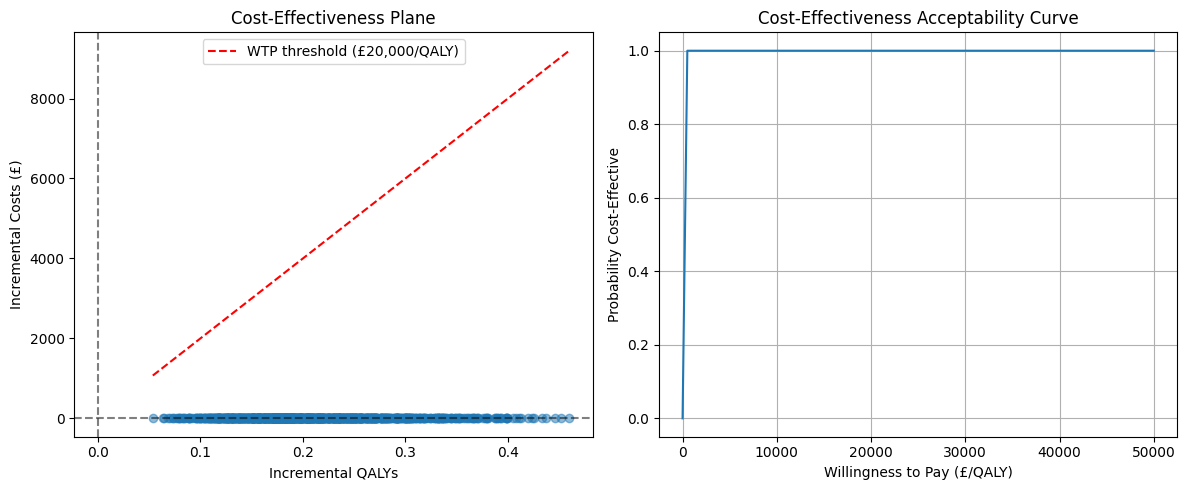


PSA Summary Statistics:
Mean Incremental Costs: £7.26
95% CI: (£3.28 to £12.83)

Mean Incremental QALYs: 0.211
95% CI: (0.096 to 0.380)

Probability Cost-Effective at £20,000/QALY: 100.0%


In [29]:


@dataclass
class MarkovParameters:
    tp_prog: float
    tp_dcm: float
    tp_dn: Dict[str, float]
    costs: Dict[str, float]
    utilities: Dict[str, float]
    cycle_length: float
    effectiveness: float
    initial_age: int
    outcome_discount: float
    cost_discount: float

@dataclass
class ParameterDistribution:
    mean: float
    distribution: str  # 'beta', 'gamma', 'normal'
    param1: float  # alpha for beta, alpha for gamma, std for normal
    param2: float = None  # beta for beta, beta for gamma

class PSAParameters:
    def __init__(self):
        # Transition probabilities (Beta distributions)
        self.tp_prog = ParameterDistribution(0.01, 'beta', 10, 990)
        self.tp_dcm = ParameterDistribution(0.15, 'beta', 15, 85)

        # Costs (Gamma distributions)
        self.costs = {
            'cAsymp': ParameterDistribution(500, 'gamma', 100, 5),
            'cProg': ParameterDistribution(3000, 'gamma', 100, 30),
            'cDrug': ParameterDistribution(1000, 'gamma', 100, 10),
            'cDeath': ParameterDistribution(1000, 'gamma', 100, 10)
        }

        # Utilities (Beta distributions)
        self.utilities = {
            'uAsymp': ParameterDistribution(0.95, 'beta', 95, 5),
            'uProg': ParameterDistribution(0.75, 'beta', 75, 25)
        }

        # Effectiveness (Beta distribution)
        self.effectiveness = ParameterDistribution(0.50, 'beta', 50, 50)

class MarkovModel:
    def __init__(self, params: MarkovParameters):
        self.params = params
        self.states = ['Asymptomatic', 'Progressive', 'Death']

    def get_age_group(self, age: int) -> str:
        if age < 65:
            return "55-64"
        elif age < 75:
            return "65-74"
        elif age < 85:
            return "75-84"
        else:
            return "85+"

    def build_transition_matrix(self, age: int, with_intervention: bool = True) -> np.ndarray:
        tp_dn = self.params.tp_dn[self.get_age_group(age)]

        tp_prog = self.params.tp_prog
        if with_intervention:
            tp_prog *= (1 - self.params.effectiveness/100)

        matrix = np.zeros((3, 3))
        matrix[0, 0] = 1 - tp_prog - tp_dn
        matrix[0, 1] = tp_prog
        matrix[0, 2] = tp_dn
        matrix[1, 1] = 1 - self.params.tp_dcm - tp_dn
        matrix[1, 2] = self.params.tp_dcm + tp_dn
        matrix[2, 2] = 1.0

        return matrix

    def run_simulation(self, n_cycles: int, with_intervention: bool = True):
        cohort = np.array([1.0, 0.0, 0.0])
        age = self.params.initial_age

        state_history = [cohort.copy()]
        costs = []
        qalys = []

        for cycle in range(n_cycles):
            P = self.build_transition_matrix(age, with_intervention)
            cohort = cohort @ P

            cycle_costs = (
                cohort[0] * self.params.costs['cAsymp'] +
                cohort[1] * self.params.costs['cProg'] +
                cohort[2] * self.params.costs['cDeath']
            )
            if with_intervention and cohort[1] > 0:
                cycle_costs += cohort[1] * self.params.costs['cDrug']

            cycle_qalys = (
                cohort[0] * self.params.utilities['uAsymp'] +
                cohort[1] * self.params.utilities['uProg']
            )

            discount_factor = 1 / (1 + self.params.outcome_discount/100) ** cycle
            costs.append(cycle_costs * discount_factor)
            qalys.append(cycle_qalys * discount_factor)
            state_history.append(cohort.copy())
            age += self.params.cycle_length

        return {
            'state_history': np.array(state_history),
            'total_costs': sum(costs),
            'total_qalys': sum(qalys)
        }

    def calculate_icer(self, n_cycles: int):
        results_with = self.run_simulation(n_cycles, with_intervention=True)
        results_without = self.run_simulation(n_cycles, with_intervention=False)

        inc_costs = results_with['total_costs'] - results_without['total_costs']
        inc_qalys = results_with['total_qalys'] - results_without['total_qalys']

        icer = inc_costs / inc_qalys if inc_qalys != 0 else float('inf')

        return {
            'intervention_costs': results_with['total_costs'],
            'intervention_qalys': results_with['total_qalys'],
            'baseline_costs': results_without['total_costs'],
            'baseline_qalys': results_without['total_qalys'],
            'incremental_costs': inc_costs,
            'incremental_qalys': inc_qalys,
            'icer': icer
        }

def run_psa(base_params: MarkovParameters, psa_params: PSAParameters, n_iterations: int, n_cycles: int):
    """Run Probabilistic Sensitivity Analysis."""
    results = []

    def sample_distribution(dist: ParameterDistribution) -> float:
        if dist.distribution == 'beta':
            return np.random.beta(dist.param1, dist.param2)
        elif dist.distribution == 'gamma':
            return np.random.gamma(dist.param1, 1/dist.param2)
        elif dist.distribution == 'normal':
            return np.random.normal(dist.mean, dist.param1)
        else:
            raise ValueError(f"Unknown distribution: {dist.distribution}")

    for _ in range(n_iterations):
        # Create new parameter set
        sampled_params = deepcopy(base_params)

        # Sample parameters
        sampled_params.tp_prog = sample_distribution(psa_params.tp_prog)
        sampled_params.tp_dcm = sample_distribution(psa_params.tp_dcm)

        for key, dist in psa_params.costs.items():
            sampled_params.costs[key] = sample_distribution(dist)

        for key, dist in psa_params.utilities.items():
            sampled_params.utilities[key] = sample_distribution(dist)

        sampled_params.effectiveness = sample_distribution(psa_params.effectiveness) * 100

        # Run model with sampled parameters
        model = MarkovModel(sampled_params)
        icer_results = model.calculate_icer(n_cycles)

        results.append({
            'inc_costs': icer_results['incremental_costs'],
            'inc_qalys': icer_results['incremental_qalys'],
            'icer': icer_results['icer']
        })

    return results

def plot_psa_results(psa_results: List[dict], wtp_threshold: float = 20000):
    """Plot PSA results."""
    inc_costs = [r['inc_costs'] for r in psa_results]
    inc_qalys = [r['inc_qalys'] for r in psa_results]

    plt.figure(figsize=(12, 5))

    # CE Plane
    plt.subplot(1, 2, 1)
    plt.scatter(inc_qalys, inc_costs, alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Incremental QALYs')
    plt.ylabel('Incremental Costs (£)')
    plt.title('Cost-Effectiveness Plane')

    qaly_range = np.array([min(inc_qalys), max(inc_qalys)])
    plt.plot(qaly_range, wtp_threshold * qaly_range, 'r--',
             label=f'WTP threshold (£{wtp_threshold:,}/QALY)')
    plt.legend()

    # CEAC
    plt.subplot(1, 2, 2)
    wtp_range = np.linspace(0, 50000, 100)
    prob_ce = [np.mean([(inc_costs[i] - wtp * inc_qalys[i]) < 0
                       for i in range(len(inc_costs))])
              for wtp in wtp_range]

    plt.plot(wtp_range, prob_ce)
    plt.xlabel('Willingness to Pay (£/QALY)')
    plt.ylabel('Probability Cost-Effective')
    plt.title('Cost-Effectiveness Acceptability Curve')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nPSA Summary Statistics:")
    print(f"Mean Incremental Costs: £{np.mean(inc_costs):,.2f}")
    print(f"95% CI: (£{np.percentile(inc_costs, 2.5):,.2f} to £{np.percentile(inc_costs, 97.5):,.2f})")
    print(f"\nMean Incremental QALYs: {np.mean(inc_qalys):.3f}")
    print(f"95% CI: ({np.percentile(inc_qalys, 2.5):.3f} to {np.percentile(inc_qalys, 97.5):.3f})")
    prob_ce_threshold = np.mean([(inc_costs[i] - wtp_threshold * inc_qalys[i]) < 0
                                for i in range(len(inc_costs))])
    print(f"\nProbability Cost-Effective at £{wtp_threshold:,}/QALY: {prob_ce_threshold * 100:.1f}%")

# Usage example:
if __name__ == "__main__":
    # Initialize base parameters
    base_params = MarkovParameters(
        tp_prog=0.01,
        tp_dcm=0.15,
        tp_dn={
            "55-64": 0.0138,
            "65-74": 0.0379,
            "75-84": 0.0912,
            "85+": 0.1958
        },
        costs={
            'cAsymp': 500,
            'cProg': 3000,
            'cDrug': 1000,
            'cDeath': 1000
        },
        utilities={
            'uAsymp': 0.95,
            'uProg': 0.75
        },
        cycle_length=1,
        effectiveness=50,
        initial_age=55,
        outcome_discount=6,
        cost_discount=6
    )

    # Initialize PSA parameters
    psa_params = PSAParameters()

    # Run PSA
    psa_results = run_psa(base_params, psa_params, n_iterations=1000, n_cycles=20)

    # Plot results
    plot_psa_results(psa_results, wtp_threshold=20000)